In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
from scipy import stats

# Census API Key
from config import census_api_key
c = Census(census_api_key, year=2017)

In [2]:
# The following code is a slightly modified version of that found in the bootcamp on sections pertaining to the census module.
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E"), {'for': 'county:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate (%)"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

# Final DataFrame
census_df = census_pd[["Name", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate (%)"]]

# Output Dataframe to csv and screen
census_df.to_csv("CSV_files/acs5_2017.csv")
census_df

,Name,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate (%)
0,"Corozal Municipio, Puerto Rico",34933.0,38.1,14752.0,7887.0,19146.0,54.807775
1,"Maunabo Municipio, Puerto Rico",11297.0,43.5,17636.0,8830.0,5945.0,52.624591
2,"Peñuelas Municipio, Puerto Rico",21661.0,36.4,16868.0,7983.0,12379.0,57.148793
3,"Ponce Municipio, Puerto Rico",148863.0,39.5,16561.0,10775.0,75187.0,50.507514
4,"San Sebastián Municipio, Puerto Rico",38970.0,42.0,14275.0,8072.0,21472.0,55.098794
...,...,...,...,...,...,...,...
3215,"Iowa County, Wisconsin",23576.0,42.5,60017.0,31717.0,2100.0,8.907363
3216,"Pepin County, Wisconsin",7282.0,45.8,51470.0,27901.0,938.0,12.881077
3217,"Ozaukee County, Wisconsin",87817.0,43.9,80526.0,45820.0,5087.0,5.792728
3218,"Portage County, Wisconsin",70371.0,36.6,54620.0,28363.0,8757.0,12.444047


In [3]:
# Broadband dataframe is pulled from csv, then limited to only values in 2017.
broadband_df = pd.read_csv("CSV_files/clean_broadband.csv")
broadband_2017_data = broadband_df.loc[broadband_df["Year"] == 2017]
broadband_2017_data.head()

,State,County,Year,GEO ID,Broadband (%),CFIPS
0,Alabama,Autauga County,2017,0500000US01001,61.818182,1001
12,Alabama,Baldwin County,2017,0500000US01003,82.068217,1003
14,Alabama,Barbour County,2017,0500000US01005,47.899160,1005
16,Alabama,Bibb County,2017,0500000US01007,60.674155,1007
18,Alabama,Blount County,2017,0500000US01009,58.669353,1009


In [4]:
# Empty array for String to be merged on is initialized 
name = []

# for loop crafts the correct string to be merged by each row.
for index, row in broadband_2017_data.iterrows():
    name.append(f'{row["County"]}, {row["State"]}')

# Dataframe to be merged, such that only 2 columns are created, is crafted    
broadband_2017_df = pd.DataFrame({"Name": name,
                                 "Broadband (%)":broadband_2017_data["Broadband (%)"],
                                 "GEO ID": broadband_2017_data["GEO ID"]})
broadband_2017_df.head()

,Name,Broadband (%),GEO ID
0,"Autauga County, Alabama",61.818182,0500000US01001
12,"Baldwin County, Alabama",82.068217,0500000US01003
14,"Barbour County, Alabama",47.899160,0500000US01005
16,"Bibb County, Alabama",60.674155,0500000US01007
18,"Blount County, Alabama",58.669353,0500000US01009


In [5]:
# Census data and broadband data are merged into one dataframe
census_2017_acs5_df = pd.merge(census_df, broadband_2017_df, how='inner', on="Name")

# Merged dataframe is saved as a csv and output
census_2017_acs5_df.to_csv("CSV_files/census_2017_acs5_df.csv")
census_2017_acs5_df.head()

,Name,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate (%),Broadband (%),GEO ID
0,"Monroe County, Alabama",21745.0,41.7,26036.0,17264.0,7249.0,33.336399,53.807104,0500000US01099
1,"Lawrence County, Alabama",33288.0,42.0,43779.0,22419.0,5490.0,16.492430,66.666663,0500000US01079
2,"Lee County, Alabama",156597.0,31.0,47564.0,26170.0,33132.0,21.157493,82.992643,0500000US01081
3,"Marion County, Alabama",30058.0,44.1,35719.0,21835.0,5175.0,17.216714,55.303031,0500000US01093
4,"Pickens County, Alabama",20170.0,42.1,36220.0,20089.0,4340.0,21.517105,57.291669,0500000US01107


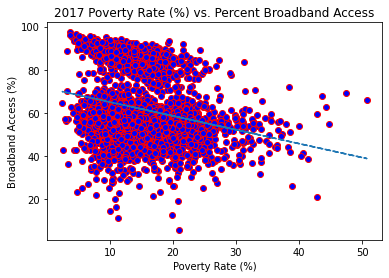

In [6]:
# This section runs a linear regression for all NAICS labels and broadband access

# Array of column headers to be analyzed against broadband access as a percent
headers = ["Population", "Median Age", "Household Income", "Per Capita Income", "Poverty Rate (%)"]

# Arrays to hold r and r-squared values are initilaized
r_squared = []
r_values = []

# for loop looping through each header
for header in headers:

    # Clears figure so plots do not superimpose
    plt.clf()
    
    # Lists for x and y values are defined
    x = census_2017_acs5_df[header]
    y = census_2017_acs5_df['Broadband (%)']

    # Linear regression is run
    header_slope, header_int, header_r, p, std_err = stats.linregress(x ,y)
    header_fit = header_slope * x + header_int

    # Plot is crafted and labeled then linear regression and r-squared is superimposed
    plt.scatter(x ,y , marker="o", facecolors="blue", edgecolors="red")
    plt.title(f'2017 {header} vs. Percent Broadband Access')
    plt.xlabel(header)
    plt.ylabel("Broadband Access (%)")
    plt.plot(x , header_fit,"--")
    
    # r_squared values are added to a list
    r_squared.append(f'The r-squared for {header} is {round(header_r**2,3)}.')
    r_values.append(f'The r-value for {header} is {round(header_r,3)}.')

    # plot is output and saved as a png
    plt.savefig(f'output_charts/2017_acs5_{header}_lin_regress.png',format='png')

In [7]:
r_squared

['The r-squared for Population is 0.145.',
 'The r-squared for Median Age is 0.07.',
 'The r-squared for Household Income is 0.204.',
 'The r-squared for Per Capita Income is 0.176.',
 'The r-squared for Poverty Rate (%) is 0.06.']

In [8]:
r_values

['The r-value for Population is 0.381.',
 'The r-value for Median Age is -0.265.',
 'The r-value for Household Income is 0.452.',
 'The r-value for Per Capita Income is 0.419.',
 'The r-value for Poverty Rate (%) is -0.244.']